In [1]:
import sklearn.model_selection
import sklearn.preprocessing
import sklearn.preprocessing
import sklearn.linear_model
import sklearn.pipeline
import sklearn.datasets
import sklearn.metrics
import matplotlib.pyplot as plt
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)

## 4.6 逻辑回归
正如我们在第1章中讨论的那样，一些回归算法也可以用于分类(反之亦然)。`Logistic回归`(也称为`Logit回归`)通常用于估计一个实例属于某个特定类别的概率(例如，这电子邮件是垃圾邮件的概率是多少？)。 如果估计的概率大于`50%`，那么模型预测这个实例属于当前类(称为`正类`，标记为`1`)，反之预测它不属于当前类(即它属于`负类` ，标记为`0`)。 这样便成为了一个`二元分类器`。

### 4.6.1 概率估计
那么它是怎样工作的？ 就像线性回归模型一样，Logistic回归模型计算输入特征的加权和(加上偏差项)，但它不像线性回归模型那样直接输出结果，而是把结果输入`logistic()`函数进行二次加工后进行输出(详见`公式4-13`)：

+ $\hat{p}=h_\theta(\mathbf{x})=\sigma(\theta^T  \cdot \mathbf{x})$

Logistic函数(也称为`logit`)，用$\sigma()$表示，其是一个$sigmoid 函数$(图像呈$S$型)，它的输出是一个介于0和1之间的数字。其定义如`公式4-14`和`图4-21`所示：

+ $\sigma(t)=\frac{1}{1+exp(-t)}$

<img src="images/04_21.png" style="width:500px;"/>

一旦`Logistic回归模型`估计得到了$\mathbf{x}$属于正类的概率$\hat{p}=h_\theta(\mathbf{x})$，那它很容易得到预测结果$\hat{y}$(见`公式4-15`)：

+ $\hat{y}= \begin{cases} 0, &\hat{p}<0.5 \\ 1,&\hat{p}\geq0.5 \\ \end{cases}$

注意当$t<0$时，$\sigma(t)<0.5$，当$t\geq0$时$\sigma(t)\geq0.5$，因此当$\theta^T  \cdot \mathbf{x}$是正数的话，逻辑回归模型输出1，如果它是负数的话，则输出0。

对线性回归来说，对于岭回归，我们可以使用封闭方程去计算，也可以使用梯度下降去处理。它们的缺点和优点是一样的。`公式4-9`表示封闭方程的解(矩阵$\mathbf{A}$是一个除了左上角有一个0的$n \times n$的单位矩阵，这个0代表偏差项，偏差$\theta_0$不被正则化的)。
+ $\hat{\theta} = ({\mathbf{X}}^T\cdot\mathbf{X}+\alpha\mathbf{A})^{-1}\cdot{\mathbf{X}}^T\cdot\mathbf{y}$

下面是如何使用`Scikit-Learn`来进行封闭方程的求解(使用`Cholesky法`进行矩阵分解对`公式4-9`进行变形）:

### 4.6.2 训练和损失函数
好，现在你知道了Logistic回归模型如何估计概率并进行预测。 但是它是如何训练的？ 训练的目的是设置参数向量$\theta$，使得正例($y=1$)概率增大，负例($y=0$)的概率减小，其通过在单个训练实例$\mathbf{x}$的损失函数来实现(`公式4-16`)：

+ $c(\theta)= \begin{cases} -log(\hat{p}), &y=1 \\ -log(1-\hat{p}),&y=0 \ \end{cases}$

这个损失函数是合理的，因为当$t$接近0时，$-log(t)$变得非常大，所以如果模型估计一个正例概率接近于0，那么损失函数将会很大，同时如果模型估计一个负例的概率接近1，那么损失函数同样会很大。 另一方面，当t接近于1时，$-log(t)$接近0，所以如果模型估计一个正例概率接近于0，那么损失函数接近于0，同时如果模型估计一个负例的概率接近0，那么损失函数同样会接近于0， 这正是我们想的。

整个训练集的损失函数只是所有训练实例的平均值。可以用一个表达式(你可以很容易证明)来统一表示，称为`对数损失`，如`公式4-17`所示：

+ $J(\theta)=-\frac{1}{m}\sum\limits_{i=1}^m\left[y^{(i)}log\left(\hat{p}^{(i)}\right)+\left(1-y^{(i)}\right)log\left(1-\hat{p}^{(i)}\right)\right]$

但是这个损失函数对于求解最小化损失函数的$\theta$是没有公式解的(没有等价的正规方程)。 但好消息是，这个损失函数是凸的，所以梯度下降(或任何其他优化算法)一定能够找到全局最小值(如果学习速率不是太大，并且你等待足够长的时间)。`公式4-18`给出了损失函数关于第$j$个模型参数$\theta_j$的偏导数：

+ $\frac{\partial}{\partial \theta_j}J(\theta_j)=\frac{1}{m} \sum\limits_{i=1}^m{\left(\sigma\left(\theta^T \cdot \mathbf{x}^{(i)}\right)-y^{(i)}\right)}{x_j}^{(i)}$

这个公式看起来非常像`公式4-5`：首先计算每个样本的预测误差，然后误差项乘以第$j$项特征值，最后求出所有训练样本的平均值。一旦你有了包含所有的偏导数的梯度向量，你便可以在梯度向量上使用批量梯度下降算法。 也就是说：你已经知道如何训练Logistic回归模型。 对于随机梯度下降，你当然只需要每一次使用一个实例，对于小批量梯度下降，你将每一次使用一个小型实例集。

### 4.6.3 决策边界
我们使用鸢尾花数据集来分析Logistic回归。 这是一个著名的数据集，其中包含150朵三种不同的鸢尾花的萼片和花瓣的长度和宽度。这三种鸢尾花为：`Setosa`，`Versicolor`，`Virginica`(如`图4-22`)。

<img src="images/04_22.png" style="width:500px;"/>

让我们尝试建立一个分类器，仅仅使用花瓣的宽度特征来识别`Virginica`，首先让我们加载数据：

/home/alex/3rd/py-venv/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


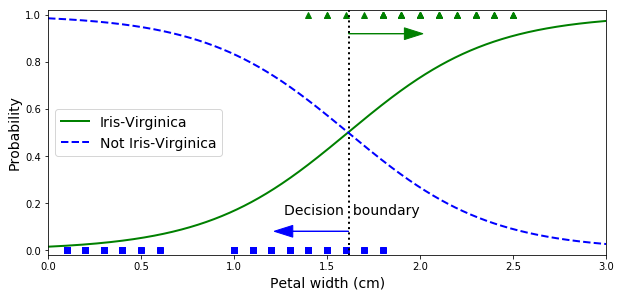

In [2]:
iris = sklearn.datasets.load_iris()

X = iris["data"][:, 3:] # petal width
y = (iris["target"] == 2).astype(np.int) # 1 if Iris-Virginica, else 0

log_reg = sklearn.linear_model.LogisticRegression() 
log_reg.fit(X, y)

X_new = np.linspace(0, 3, 1000).reshape(-1, 1)
y_proba = log_reg.predict_proba(X_new)
decision_boundary = X_new[y_proba[:, 1] >= 0.5][0]

plt.figure(figsize=(10, 4.5))
plt.plot(X[y==0], y[y==0], "bs")
plt.plot(X[y==1], y[y==1], "g^")
plt.plot([decision_boundary, decision_boundary], [-1, 2], "k:", linewidth=2)
plt.plot(X_new, y_proba[:, 1], "g-", linewidth=2, label="Iris-Virginica")
plt.plot(X_new, y_proba[:, 0], "b--", linewidth=2, label="Not Iris-Virginica")
plt.text(decision_boundary+0.02, 0.15, "Decision  boundary", fontsize=14, color="k", ha="center")
plt.arrow(decision_boundary, 0.08, -0.3, 0, head_width=0.05, head_length=0.1, fc='b', ec='b')
plt.arrow(decision_boundary, 0.92, 0.3, 0, head_width=0.05, head_length=0.1, fc='g', ec='g')
plt.xlabel("Petal width (cm)", fontsize=14)
plt.ylabel("Probability", fontsize=14)
plt.legend(loc="center left", fontsize=14)
plt.axis([0, 3, -0.02, 1.02])
plt.show()

`Virginica`花的花瓣宽度(用三角形表示)在1.4厘米到2.5厘米之间，而其他种类的花(由正方形表示)通常具有较小的花瓣宽度，范围从0.1厘米到1.8厘米。注意，它们之间会有一些重叠。在大约2厘米以上时，分类器非常肯定这朵花是Virginica花(分类器此时输出一个非常高的概率值)，而在1厘米以下时，它非常肯定这朵花不是Virginica花(不是Virginica花有非常高的概率)。在这两个极端之间，分类器是不确定的。但是，如果你使用它进行预测(使用`predict()`方法而不是`predict_proba()`方法)，它将返回一个最可能的结果。因此，在1.6厘米左右存在一个决策边界，这时两类情况出现的概率都等于50%：如果花瓣宽度大于1.6厘米，则分类器将预测该花是Virginica，否则预测它不是(即使它有可能错了)：

In [3]:
log_reg.predict([[1.7], [1.5]])

array([1, 0])

`图4-24`表示相同的数据集，但是这次使用了两个特征进行判断：花瓣的宽度和长度。 一旦训练完毕，Logistic回归分类器就可以根据这两个特征来估计一朵花是Virginica的可能性。 虚线表示这时两类情况出现的概率都等于50%：这是模型的决策边界。 请注意，它是一个线性边界。每条平行线都代表一个分类标准下的两两个不同类的概率，从15%(左下角)到90%(右上角)。越过右上角分界线的点都有超过90%的概率是Virginica花。

/home/alex/3rd/py-venv/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


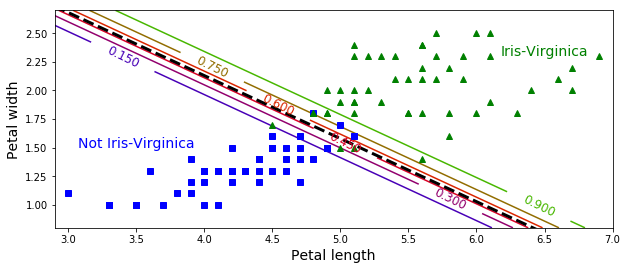

In [4]:
X = iris["data"][:, (2, 3)]  # petal length, petal width
y = (iris["target"] == 2).astype(np.int)

log_reg = sklearn.linear_model.LogisticRegression(C=10**10, random_state=42)
log_reg.fit(X, y)

x0, x1 = np.meshgrid(
        np.linspace(2.9, 7, 500).reshape(-1, 1),
        np.linspace(0.8, 2.7, 200).reshape(-1, 1),
    )
X_new = np.c_[x0.ravel(), x1.ravel()]

y_proba = log_reg.predict_proba(X_new)

plt.figure(figsize=(10, 4))
plt.plot(X[y==0, 0], X[y==0, 1], "bs")
plt.plot(X[y==1, 0], X[y==1, 1], "g^")

zz = y_proba[:, 1].reshape(x0.shape)
contour = plt.contour(x0, x1, zz, cmap=plt.cm.brg)


left_right = np.array([2.9, 7])
boundary = -(log_reg.coef_[0][0] * left_right + log_reg.intercept_[0]) / log_reg.coef_[0][1]

plt.clabel(contour, inline=1, fontsize=12)
plt.plot(left_right, boundary, "k--", linewidth=3)
plt.text(3.5, 1.5, "Not Iris-Virginica", fontsize=14, color="b", ha="center")
plt.text(6.5, 2.3, "Iris-Virginica", fontsize=14, color="g", ha="center")
plt.xlabel("Petal length", fontsize=14)
plt.ylabel("Petal width", fontsize=14)
plt.axis([2.9, 7, 0.8, 2.7])
plt.show()

就像其他线性模型，逻辑回归模型也可以$\ell_1$或者$\ell_2$惩罚使用进行正则化。`Scikit-Learn`默认添加了$\ell_2$惩罚。

> **注意**
> 
> 在`Scikit-Learn`的LogisticRegression模型中控制正则化强度的超参数不是$\alpha$(与其他线性模型一样)，而是它的逆：`C`。`C`的值越大，模型正则化强度越低

### 4.6.4 Softmax 回归
Logistic回归模型可以直接推广到支持多类别分类，不必组合和训练多个二分类器(如`第3章`所述)， 其称为`Softmax回归`或`多类别Logistic回归`。

这个想法很简单：当给定一个实例$\mathbf{x}$时，Softmax回归模型首先计算$k$类的分数$s_k(\mathbf{x})$，然后将分数应用在`Softmax函数`(也称为`归一化指数`)上，估计出每类的概率。 计算$s_k(\mathbf{x})$的公式看起来很熟悉，因为它就像线性回归预测的公式一样(见`公式4-19`)：

+ $s_k(\mathbf{x})= \theta^T  \cdot \mathbf{x}$

注意，每个类都有自己独一无二的参数向量$\theta_k$。 所有这些向量通常作为行放在参数矩阵$\Theta$中。

一旦你计算了样本$\mathbf{x}$的每一类的得分，你便可以通过`Softmax函数`(`公式4-20`)估计出样本属于第$k$类的概率$\hat{p}_k$：通过计算$e$的$s_k(\mathbf{x})$次方，然后对它们进行归一化(除以所有分子的总和)：

+ $\displaystyle \hat{p_k}=\sigma{(\mathbf{s}(\mathbf{x}))}k= \frac{exp\left(s_k(\mathbf{x})\right)} {\sum_{j=1}^{K}exp\left(s_j(\mathbf{x})\right)}$
    + $K$表示有多少类
    + $\mathbf{s}(\mathbf{x})$表示包含样本$\mathbf{x}$每一类得分的向量
    + $\sigma{(\mathbf{s}(\mathbf{x}))_k}$表示给定每一类分数之后，实例$\mathbf{x}$属于第$k$类的概率

和Logistic回归分类器一样，Softmax回归分类器将估计概率最高(它只是得分最高的类)的那类作为预测结果，如`公式4-21`所示：

+ $\hat{y}=argmax\ \sigma{(\mathbf{s}(\mathbf{x}))_k}=argmax \ s_k(\mathbf{x})=argmax \ \left( \theta_k^T  \cdot \mathbf{x}\right)$
    + $argmax$运算返回一个函数取到最大值的变量值。在这个等式，它返回使$\sigma{(\mathbf{s}(\mathbf{x}))_k}$最大时的$k$的值

> Softmax回归分类器一次只能预测一个类(即它是多类的，但不是多输出的)，因此它只能用于判断互斥的类别，如不同类型的植物。 你不能用它来识别一张照片中的多个人

现在我们知道这个模型如何估计概率并进行预测，接下来将介绍如何训练。我们的目标是建立一个模型在目标类别上有着较高的概率(因此其他类别的概率较低)，最小化`公式4-22`可以达到这个目标，其表示了当前模型的损失函数，称为`交叉熵`，当模型对目标类得出了一个较低的概率，其会惩罚这个模型。 `交叉熵`通常用于衡量待测类别与目标类别的匹配程度(我们将在后面的章节中多次使用它)：

+ $J(\Theta)=-\frac{1}{m}\sum\limits_{i=1}^m\sum\limits_{k=1}^Ky_k^{(i)}log\left(\hat{p}_k^{(i)}\right)$
    + 如果对于第$i$个实例的目标类是$k$，那么$y_k^{(i)}=1$，反之$y_k^{(i)}=0$

可以看出，当只有两个类($K=2$)时，此损失函数等同于Logistic回归的损失函数(对数损失；请参阅`公式 4-17`)。

> **交叉熵**
> 
> 交叉熵源于信息论。假设你想要高效地传输每天的天气信息。如果有八个选项(晴天，雨天等)，则可以使用3位对每个选项进行编码，因为$2^3=8$。但是，如果你认为几乎每天都是晴天，更高效的编码`晴天`的方式是：只用一位(0)。剩下的七项使用四位(从1开始)。交叉熵度量每个选项实际发送的平均比特数。 如果你对天气的假设是完美的，交叉熵就等于天气本身的熵(即其内部的不确定性)。 但是，如果你的假设是错误的(例如，如果经常下雨)交叉熵将会更大，称为`Kullback-Leibler散度`(KL散度)
> 
> 两个概率分布$p$和$q$之间的交叉熵定义为：$H(p,q)=-\sum_xp(x)\log q(x)$(分布至少是离散的)

这个损失函数关于$\theta_k$的梯度向量为`公式4-23`：

+ $\nabla_{\theta_k}J(\Theta)=\frac{1}{m}\sum\limits_{i=1}^m\left(\hat{p}_k^{(i)}-y_k^{(i)}\right)\mathbf{x}^{(i)}$

现在你可以计算每一类的梯度向量，然后使用梯度下降(或者其他的优化算法)找到使得损失函数达到最小值的参数矩阵$\Theta$。

让我们使用`Softmax回归`对三种鸢尾花进行分类。当你使用LogisticRregression对模型进行训练时，`Scikit-Learn`默认使用的是一对多模型，但是你可以设置`multi_class`参数为`multinomial`来把它改变为`Softmax回归`。你还必须指定一个支持`Softmax回归`的求解器，例如`lbfgs`求解器(有关更多详细信息，请参阅`Scikit-Learn`的文档)。其默认使用$\ell_2$正则化，你可以使用超参数$C$控制它。

In [5]:
X = iris["data"][:, (2, 3)]  # petal length, petal width
y = iris["target"]

softmax_reg = sklearn.linear_model.LogisticRegression(multi_class="multinomial",solver="lbfgs", C=10) 
softmax_reg.fit(X, y)

# ask the model an iris with 5 cm long and 2 cm wide petals what type of iris it is
# it will answer Iris-Virginica (class 2)
softmax_reg.predict([[5, 2]])

array([2])

所以下次你发现一个花瓣长为5厘米，宽为2厘米的鸢尾花时，你可以问你的模型你它是哪一类鸢尾花，它会回答`94.2%`是Virginica花(第二类)，或者`5.8%`是其他鸢尾花。

In [6]:
softmax_reg.predict_proba([[5, 2]])

array([[6.38014896e-07, 5.74929995e-02, 9.42506362e-01]])

`图4-25`用不同背景色表示了结果的决策边界。注意，任何两个类之间的决策边界是线性的。该图的曲线表示Versicolor类的概率(例如，用`0.450`标记的曲线表示`45%`的概率边界)。注意模型也可以预测一个概率低于50%的类。 例如，在所有决策边界相遇的地方，所有类的估计概率相等，分别为33%。